# A small neural network that predicts whether float is > 0. Only using numpy & pyplot. Which is actually quite a lot. 
# I started from math on paper so a lot of stuff is inefficient. Like column vectors.

In [1825]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

# Let's define useful stuff & check it.

In [1794]:
#uniformly random normalised matrix for weights, biases & tests;
def unm(m, n):
    matrix = np.random.uniform(-3, 3, size=(m,n))
    return matrix #/ np.sqrt(m*n)

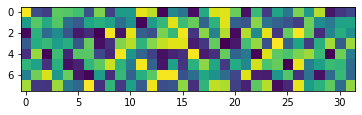

In [133]:
plt.imshow(unm(8, 32))
plt.show()

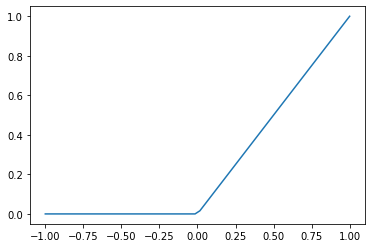

In [428]:
#for hidden layer activation
relu = lambda x: np.maximum(x, 0.)

x = np.linspace(-1, 1, 64)
plt.plot(x, relu(x))
plt.show()

In [246]:
#for last layer activation
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

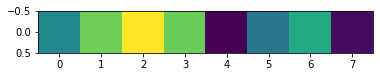

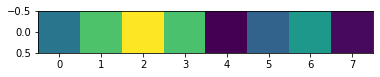

sum(softmax(x)) =  1.0
nice!


In [247]:
x = unm(8, 1)
plt.imshow(x.T)
plt.show()

plt.imshow(softmax(x.T))
plt.show()

#it's good if sum is ~1.0;
print("sum(softmax(x)) = ", float(sum(softmax(x))))
print("nice!")

In [248]:
#so it would work well with a whole batch
def matrix_softmax(m):
    return np.apply_along_axis(softmax, 0, m)

t = unm(2,3)
print(t)
matrix_softmax(t)

[[ 0.18857642 -0.07648703  0.32152286]
 [ 0.09134618 -0.23759772 -0.27932191]]


array([[0.52428843, 0.54019078, 0.64584955],
       [0.47571157, 0.45980922, 0.35415045]])

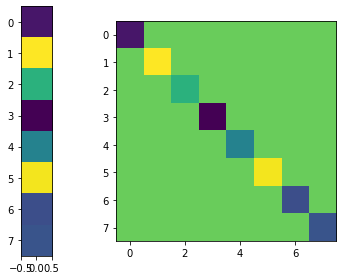

In [431]:
#returns diagonal matrix with entries from column vector v;
#there's actually no need to do this;
def dm(v):
    l = len(v)
    m = np.zeros([l, l])
    np.fill_diagonal(m, v)
    return m

v = unm(8,1)
plt.subplot(1,2,1)
plt.imshow(v)
plt.subplot(1,2,2)
plt.imshow(dm(v))
plt.tight_layout()

# Stuff's ready - let's do a draft.

In [1795]:
'''
individual forward path takes float -1 < x < 1
and tries to predict probability distribution of it being > 0;
    0.5  -> [1, 0]
    -0.7 -> [0, 1]
       x -> [1 if (x > 0) else 0, 1 if (x < 0) else 0]
       
a good model would do something like:
    0.1 -> [0.7, 0.3]
   -0.2 -> [0.2, 0.8]
   loss is cross entropy between [0, 1] and [0.2, 0.8];
'''

#random weight & biases
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)


#layers are x before activation and l after
#input = x0
x0 = np.array([[0.5],[5],[3]]).T

#hidden layer
x1 = x0 * W0 + b0
l1 = relu(x1)

#l2 is output
x2 = W1 @ l1 + b1
l2 = softmax(x2)


dloss_dx2 = (l2 - np.zeros(l2.shape)).T

#jacobians for computing 4 useful gradients;
dx2_dl1 = W1
dl1_dx1 = dm(l1>0)
dx1_dW0 = x0
dx2_dW1 = (l1.T)

#chain rule for jacobians produces gradients;
#these 4 will be used in SGD;
#but like any enterprise, when under a new management, 
#there's always a slight duplication of efforts;


print("W0", W0.shape)
print(dx1_dW0.shape, dloss_dx2.shape, dx2_dl1.shape, dl1_dx1.shape)



dloss_dW0 =  (dx1_dW0 @ (dloss_dx2 @ dx2_dl1) @ dl1_dx1).T


dloss_dW1 = dloss_dx2.T @ dx2_dW1
dloss_db0 = ((dloss_dx2 @ dx2_dl1 @ dl1_dx1).T).sum(axis=1).reshape(-1,1)

dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)


#seems to work!
print("Shapes work:")

print("W1", W1.shape)
print("dloss_dW1", dloss_dW1.shape)

print("W0", W0.shape)
print("dloss_dW0", dloss_dW0.shape)

print("b0", b0.shape)
print("dloss_db0", dloss_db0.shape)

print("b1", b1.shape)
print("dloss_db1", dloss_db1.shape)

W0 (8, 1)
(1, 3) (3, 2) (2, 8) (8, 8)
Shapes work:
W1 (2, 8)
dloss_dW1 (2, 8)
W0 (8, 1)
dloss_dW0 (8, 1)
b0 (8, 1)
dloss_db0 (8, 1)
b1 (2, 1)
dloss_db1 (2, 1)


In [747]:
dx2_dl1.shape

(2, 8)

# Let's write a function that returns gradients.

In [1751]:
def grads(train, labels, W0, W1, b0, b1):
    
    '''
    -> dloss_dW0, dloss_dW1, dloss_db0, dloss_db1
    
    The vagones of the row vector train (np.array) are floats.
    Each one of them is a training example. 
    And has a corresponding lable in labels.
    In my particular case each lables[i] is a column [1, 0] if train[i] > 0,
    and a column [0, 1] otherwise.
    The length of train is the batch size.
    W & b are weights & biases.
    Returns gradients of W & b.
    '''
    x0 = train

    x1 = W0 @ x0 + b0
    l1 = relu(x1)

    x2 = W1 @ l1 + b1
    l2 = softmax(x2)

    dloss_dx2 = (l2 - labels).T
    
    dx2_dl1 = W1
    dl1_dx1 = dm(l1>0)
    dx1_dW0 = x0
    dx2_dW1 = (l1.T)
    
    #this is definately wrong; i have no idea why it works so well;
    #dloss_dW0 =   (dx1_dW0 @ (dloss_dx2 @ dx2_dl1) @ dl1_dx1).T
    dloss_dW0 = ((dloss_dx2 @ dx2_dl1) @ dl1_dx1).T @ dx1_dW0
    dloss_dW1 = dloss_dx2.T @ dx2_dW1
    dloss_db0 = ((dloss_dx2 @ dx2_dl1 @ dl1_dx1).T).sum(axis=1).reshape(-1,1)
    dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)

    return (dloss_dW0, dloss_dW1, dloss_db0, dloss_db1)

In [1005]:
#generate smol data;
small_train = unm(1, 10)
small_lables = np.array([np.array([1, 0]) if el > 0 else np.array([0, 1]) for el in small_train[0]]).T

Train:


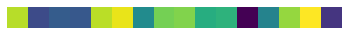

Lables:


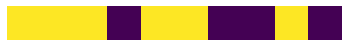

Very nice!
We get pure hot, where it used to be hotter than 0.
And super chill, where it used to be < 0.


In [740]:
#let's check how reasonable the lables are;
#we don't do these things because they are easy;
#we choose to go to the moon because it's hard;

plt.imshow(small_train)
plt.axis('off')
print("Train:")
plt.show()

plt.axis('off')
check_lables = np.array([(small_lables.T[i][0] == 1) + 0. for i in range(10)])
plt.imshow(check_lables.reshape(1, 10))
print("Lables:")
plt.show()

print("Very nice!\nWe get pure hot, where it used to be hotter than 0.\nAnd super chill, where it used to be < 0.")

In [1043]:
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)

grads(small_train, small_lables, W0, W1, b0, b1)

(array([[ 0.04737542],
        [-0.18419327],
        [ 0.12063817],
        [ 0.03853042],
        [ 0.        ],
        [ 0.20847531],
        [-0.27341949],
        [ 0.17882343]]),
 array([[ 0.00842655, -0.71595386, -0.10607397, -0.07302928, -0.18372525,
          0.        , -0.54286127,  0.        ],
        [-0.13484052, -1.72745437, -0.00607026, -0.63888012, -1.09891062,
          0.        , -1.91188383,  0.        ]]),
 array([[-0.88639716],
        [ 0.79532901],
        [-0.97235857],
        [ 0.71471972],
        [ 0.        ],
        [-0.89730669],
        [ 1.37851481],
        [-1.31554135]]),
 array([[-2.35505523],
        [-6.64494477]]))

In [1028]:
#generating a lot of data
def data(bs):
    small_train = unm(1, bs)
    small_lables = np.array([np.array([1, 0]) if el > 0 else np.array([0, 1]) for el in small_train[0]]).T
    return (small_train, small_lables)

# We are ready for training!

In [1979]:
#let's do data for 5 epoches with 256 batch size
examples = [data(512) for _ in range(5)]

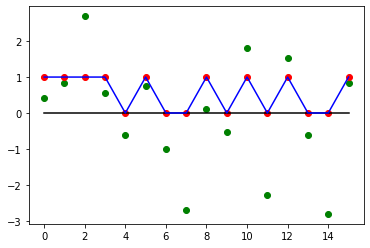

In [2024]:
#random initial parameters
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)

#training loop
lr = 0.01
for batch in examples:
    x, y = batch
    #SGD
    dloss_dW0, dloss_dW1, dloss_db0, dloss_db1 = grads(x, y, W0, W1, b0, b1)
    W0 = W0 - dloss_dW0 * lr
    W1 = W1 - dloss_dW1 * lr
    b0 = b0 - dloss_db0 * m  lr
    b1 = b1 - dloss_db1 * lr
    
#works like a good chap, doesn't it?


x0 = data(16)[0]
x1 = W0 @ x0 + b0
l1 = relu(x1)

x2 = W1 @ l1 + b1
l2 = matrix_softmax(x2)

plt.plot(x0.T, 'go')
plt.plot([round((l2.T)[i][0], 4) for i in range(16)], 'ro')
plt.plot([0 for _ in range(16)], 'k')
plt.plot(sign(x0.T), 'b')

In [1811]:
np.array([[0.4], [-0.5], [-0.6]])

array([[ 0.4],
       [-0.5],
       [-0.6]])

In [1850]:
x0 = data(16)[0]
x1 = W0 @ x0 + b0
l1 = relu(x1)

x2 = W1 @ l1 + b1
l2 = matrix_softmax(x2)


array([[0.00391369, 0.84303783, 0.99972817, 0.99963874, 0.00066784,
        0.00000701, 0.59121311, 0.6098459 , 0.99706756, 0.97598853,
        0.00097833, 0.00001045, 0.00114933, 0.00029083, 0.99798111,
        0.00054685],
       [0.99608631, 0.15696217, 0.00027183, 0.00036126, 0.99933216,
        0.99999299, 0.40878689, 0.3901541 , 0.00293244, 0.02401147,
        0.99902167, 0.99998955, 0.99885067, 0.99970917, 0.00201889,
        0.99945315]])

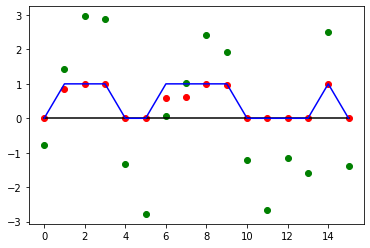

In [1858]:
plt.plot(x0.T, 'go')
plt.plot([round((l2.T)[i][0], 4) for i in range(16)], 'ro')
plt.plot([0 for _ in range(16)], 'k')
plt.plot(sign(x0.T), 'b')

In [1849]:
[round((l2.T)[i][0], 4) for i in range(16)]

[0.0, 0.0015, 0.989]

In [1848]:
l2

array([[0.00000559, 0.00147993, 0.98896567],
       [0.99999441, 0.99852007, 0.01103433]])

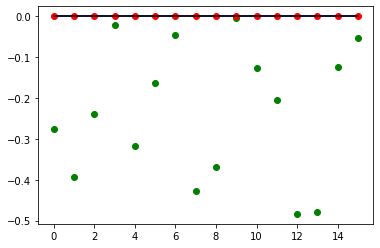

In [1296]:
#works like a good chap, doesn't it?

x_test = unm(16, 1)
y_test = sign(x_test)

plt.plot(x_test, 'go')
plt.plot(y_test, 'b')
plt.plot(pred(x_test), 'ro')
plt.plot(np.zeros(16), 'k')
plt.show()

In [435]:
with open('params.npy', 'wb') as f:
    np.save(f, W0)
    np.save(f, W1)
    np.save(f, b0)
    np.save(f, b1)

In [436]:
with open('params.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    c = np.load(f)
    d = np.load(f)
print(a, b, c, d)

[[3668916.04025523]
 [  -7077.90587927]
 [ -52392.3021601 ]
 [1519468.99501498]
 [4505686.9139397 ]
 [2252187.36353507]
 [1021216.52243716]
 [ -55695.07551441]] [[ 8.41444589e+01 -1.89604398e-02 -1.60080657e-01  3.61155071e+01
   1.04514834e+02  5.34842130e+01  2.36615646e+01 -1.69471002e-01]
 [ 1.17869872e+01  9.36829521e-02  4.45891869e-01  4.71995708e+00
   1.45254033e+01  7.29188108e+00  3.49843755e+00  4.13577007e-01]] [[14.52021492]
 [-0.6263796 ]
 [-0.72768547]
 [ 6.0878918 ]
 [17.96760283]
 [ 9.11632139]
 [ 4.13749871]
 [-1.2425765 ]] [[6.01446369]
 [6.54551379]]


In [626]:
x = np.array([[2, 4]])
x

array([[2, 4]])

In [876]:
y = np.array([[1],
              [2]])
y.shape

(2, 1)

In [882]:
y @ np.array([[3], [4]]).T

array([[3, 4],
       [6, 8]])

In [880]:
np.array([1, 2]).shape

(2,)

In [883]:
np.array([[3], [4]]).T

array([[3, 4]])

In [1823]:
np.set_printoptions(suppress=True)

In [1698]:
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)



x0 = np.array([[0.001, 0.9]])
x1 = W0 @ x0 + b0
l1 = relu(x1)

x2 = W1 @ l1 + b1
l2 = matrix_softmax(x2)
l2

array([[0.98923998, 0.88902889],
       [0.01076002, 0.11097111]])

In [1699]:
x0 = np.array([[0.001], [-0.5]]).T

x1 = W0 @ x0 + b0
l1 = relu(x1)

x2 = W1 @ l1 + b1
l2 = matrix_softmax(x2)
l2

array([[0.98923998, 0.99215094],
       [0.01076002, 0.00784906]])

In [1700]:
pred()

array([[-1.69694733],
       [-2.44243818],
       [ 0.3563088 ],
       [ 2.09561408],
       [ 2.69637464],
       [-1.50290703],
       [-2.71339844],
       [ 1.85288496]])

In [1701]:
W0 @ x0

array([[ 0.00085412, -0.4270586 ],
       [-0.00177392,  0.88695759],
       [-0.00200992,  1.00496139],
       [ 0.00180135, -0.90067409],
       [ 0.00234847, -1.17423264],
       [-0.00207476,  1.03737989],
       [ 0.00162073, -0.81036304],
       [-0.00058826,  0.29412796]])